In [10]:
import os
import json
import numpy as np

import matplotlib.pyplot as plt
from monai.data import ImageDataset
from monai.transforms import Resize, EnsureChannelFirst, Compose
from torch.utils.data import DataLoader

from evaluate_util import get_model

In [6]:
exp_path = "experiments/" + "2024_03_08__10_17_28" + "/"
with open(exp_path + "config.json", 'r') as file:
    config = json.load(file)

model_config = config["model_config"]

transformer = Compose([EnsureChannelFirst(),
                       Resize(config["image_size"])])

val_image_path = "data_test/REFUGE2/Validation/Images/"
val_dm_path = "data_test/REFUGE2/Validation/Disc_Masks/"

val_data = ImageDataset(image_files=[val_image_path + file for file in os.listdir(val_image_path)],
                          transform=transformer,
                          seg_files=[val_dm_path + file for file in os.listdir(val_dm_path)],
                          seg_transform=transformer)

train_dataloader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=True)

In [37]:
def plot_sample(sample):
    fig, (img1, img2) = plt.subplots(1, 2, layout="constrained")

    img1.imshow(sample[0].permute(1, 2, 0) / 255)
    img1.set_axis_off()

    disc_image = np.stack([np.array(sample[1][0, :, :]),
                           np.zeros(shape=(sample[0].shape[1], sample[0].shape[2])),
                           np.array(sample[1][1, :, :])])

    img2.imshow(np.transpose(disc_image, (1, 2, 0)))
    img2.set_axis_off()
    plt.show()

In [8]:
model, _ = get_model(exp_path, model_config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


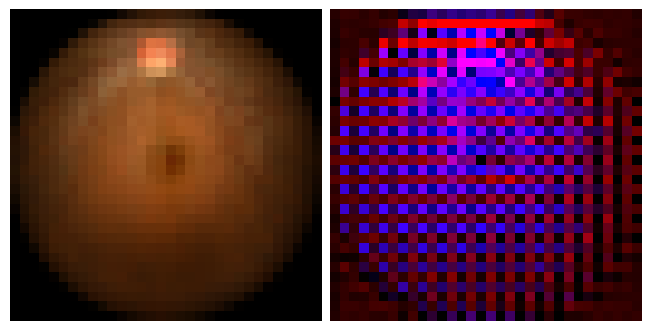

In [38]:
for batch in train_dataloader:
    new_images = model(batch[0])
    plot_sample((batch[0][0], new_images[0].detach()))
    break